# Random Walk
In this notebook the Causal Variational Approach (CVA) to the Conditioned Random Walk is developed.

In [1]:
using Plots
using ForwardDiff
using ProgressMeter
ProgressMeter.ijulia_behavior(:clear);

In [2]:
# Sampling is crucial in CVA, so we have to develop a 
#sampling function
function sample!(x,θ)
    T = size(θ,2) + 1
    for t = 1:T-1
        x[t+1] = x[t] + ( rand() < θ[x[t] + T, t] ? 1 : -1 )
    end
end

sample! (generic function with 1 method)

In [3]:
# The CVA works be weighting each trajectory x sampled with the log(Q(x)).
# Therefore, we develop the logQ function to weight trajectories
function logqt(x,θt,t)
    return log((x[t+1] - x[t]) == 1 ? θt[x[t] + T] : 1 - θt[x[t] + T])
end

function logQ(x,θ)
    T = size(θ,2) + 1
    s = 0
    for t = 1:T-1
        s += logqt(x,θ[:,t],t) 
    end
    return s
end

# The next function takes into account the hard constraints
# if x is inside the allowed windows, then logO = 0
# if x instead hits a wall, then logO should be -∞
# but we soften this constraint. We put a -25 that can be modified.
function logO(x,windows)
    a = 0
    for w in windows        
        if  !(w[2] <= (x[w[1]]) <= w[3])
            a -= 25
        end
    end
    return a
end

logO (generic function with 1 method)

In [4]:
# Performing the gradient descent is crucial, so we calculate here the gradient of the free energy
function gradient!(dθ, x, θ)
    T = size(θ,2) + 1
    for t = 1:T-1
        ForwardDiff.gradient!((@view dθ[:,t]), θt -> logqt(x,θt,t), θ[:,t])
    end
end

gradient! (generic function with 1 method)

In [5]:
# This function is not used by standerd CVA.
# It is used to compare standard CVA with another version which satisfies the 
# hard constraints without any softening.
# Since we observed no substantial improvement, we kept the soft (but easier to code) version of CVA
function impose_window!(θ,window)
    for x in 1:window[1]-1
        θ[x + T,T - window[1] + x] = 1
        θ[-x + T,T - window[1] + x] = 0
    end
    for x in 0:T-1-window[2]
        θ[- window[2] - x + T,T - x - 1] = 1
        θ[x + T + window[2],T - x - 1] = 0
    end
end

impose_window! (generic function with 1 method)

In [6]:
# This function performs the gradient descent
function descend!(θ, θp, θmin, θmax, windows; numsamples=10^4, numiters=100, η=0.1)
    N = size(θ,1)
    T = size(θ,2) + 1
    dθ = zero(θ)
    x = zeros(Int, T)
    pr = Progress(numiters) 
    avF = 0
    #impose_window!(θ,window)
    for it = 1:numiters
        avF = 0
        Dθ = zero(θ)
        for s = 1:numsamples
            sample!(x, θ)
            F = logQ(x,θ) - logQ(x,θp) - logO(x,windows)
            #F =  -logO(x,windows)
            avF += F / numsamples
            gradient!(dθ, x, θ)
            Dθ .+= F .* dθ ./ numsamples
        end
        θ .-= sign.(Dθ) .* η
        θ .= clamp.(θ, θmin, θmax)
        #impose_window!(θ,window)
        ProgressMeter.next!(pr, showvalues=[(:F,sum(avF))])
    end
    return avF
end

descend! (generic function with 1 method)

In [7]:
T = 40 #total time of movement
N = 2T - 1 #total number of lattice sites


#This is an N x T matrix where θ[i,t] represents 
#the probability of jumping to right at time t for particle i
#The prob of jumping to left is 1-θ[i,t]
θ = fill(1/2,N,T-1); 
θp = fill(1/2,N,T-1); # a copy of θ for now
# The idea is that θp is kept fixed and it represents the original 
# generating process, while θ will be optimized over and will 
# describe the effective conditioned process. 

dθ = fill(1/2,N,T-1); 

# A trajectory of zeros is intialized
x = zeros(Int,T);

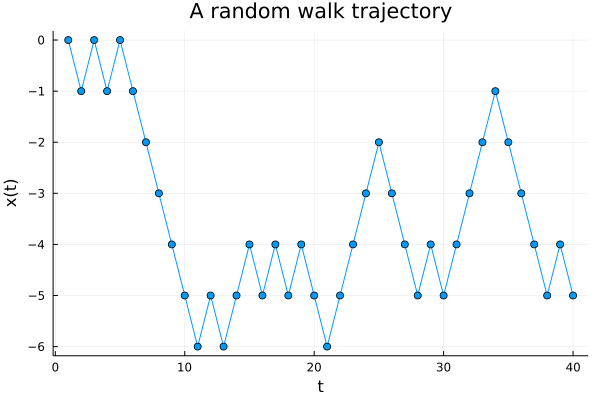

In [8]:
# We take x and we fill it with a real sample of a RW
sample!(x,θp)
plot(x,legend=false,ylabel="x(t)",xlabel="t",marker=:c,title="A random walk trajectory")

In [9]:
# Now we impose a set of windows through which the RW must pass by 
windows = [(15,5,15),(35,-15,-7),(40,-3,1)]
#The CVA method is performed!
avF = descend!(θ, θp, 1e-4, 1-1e-4, windows; numsamples=3000, numiters=40, η=0.1)
avF = descend!(θ, θp, 1e-4, 1-1e-4, windows; numsamples=3000, numiters=40, η=0.01)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:37
  F:  13.916898552068211


13.916898552068211

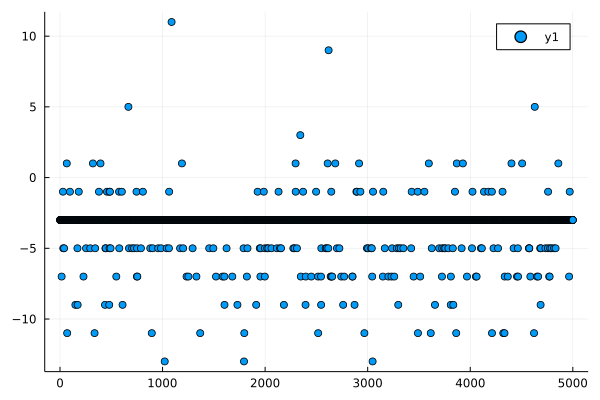

In [10]:
final_pt = zeros(5000)
p_sptime = zeros(N,T)
for st = 1:5000
    sample!(x,θ)
    #if x[end] > window[2]
     #   @show x
    #end
    for t in 1:T
        p_sptime[x[t] + T,t] += 1
    end
    final_pt[st] = x[end]
end
p_sptime ./= sum(p_sptime,dims=1)
scatter(final_pt)
#savefig("final_points.pdf")

Percentage of CM trajectories which satisfy the constraint: 92.8 %
Fraction of SoftMarg trajectories which satisfy the constraint: 3.0e-6  


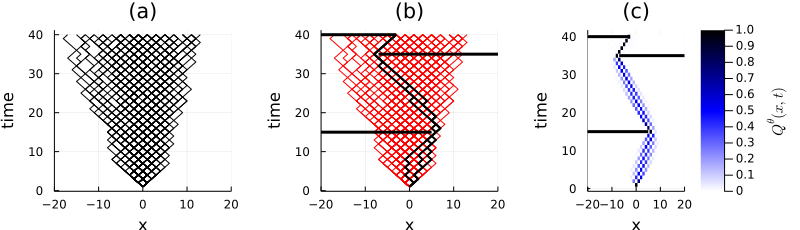

In [43]:
using LaTeXStrings
p1 = plot(x,1:T,c =:black,title="(a)") 
traject_plot = zeros(100,length(x))
for st = 1:100
    sample!(x,θp)
    traject_plot[st,:] .= x
end

for st = 2:100
    x .= traject_plot[st,:]
    p1 = plot!(x,1:T,c =:black,legend=false) 
end
x .= traject_plot[1,:]
if logO(x,windows) == 0
    p2 = plot(x ,1:T,c =:black) 
else
    p2 = plot(x ,1:T,c =:red)
end

for st = 1:100
    x .= traject_plot[st,:]
    if logO(x,windows) != 0
        p2 = plot!(x ,1:T,c =:red) 
    end
end

counterSoft = 0 
for st = 1:1000000
    sample!(x,θp)
    if logO(x,windows) == 0
        p2 = plot!(x,1:T,c =:black,lw=2) 
        counterSoft += 1
    end
end


p2 = plot!(-T:windows[1][2],(ones(windows[1][2]+T+1) .* windows[1][1]),c=:black,lw=3,title="(b)")
p2 = plot!(windows[2][3]:T, windows[2][1] .* ones(T-windows[2][3]+1),c=:black,lw=3)
p2 = plot!(-T:windows[3][2],(ones(windows[3][2]+T+1) .* windows[3][1]),c=:black,legend=false,lw=3)

counterCau = 0
for st = 1:1000
    sample!(x,θ)
    if logO(x,windows) == 0
        counterCau += 1
    end
end

p3 = heatmap(-T+1:T-1,1:T,(p_sptime)' ,c = [:white,:blue,:black],legend=true,title="(c)")
p3 = plot!(-T:windows[1][2],(ones(windows[1][2]+T+1) .* windows[1][1]),c=:black,lw=3)
p3 = plot!(windows[2][3]:T, windows[2][1] .* ones(T-windows[2][3]+1),c=:black,lw=3)
p3 = plot!(-T:windows[3][2],(ones(windows[3][2]+T+1) .* windows[3][1]),c=:black,legend=false,lw=3)

println("Percentage of CM trajectories which satisfy the constraint: $(counterCau/10) %")
println("Fraction of SoftMarg trajectories which satisfy the constraint: $(counterSoft/1000000)  ")
plot(p1, p2, p3, xlabel="x", ylabel="time", colorbar_title= L"Q^\theta(x,t)", margin=3Plots.mm, size=(800,230),xlims=(-20,20), layout = (1, 3),legend = false)

In [44]:
savefig("RWfigure.pdf")

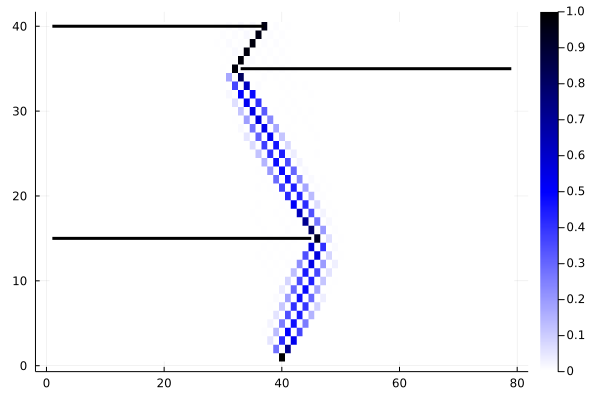

In [23]:
T = 40 #total time of movement
N = 2T - 1
cgrad(:matter)
Plots.heatmap(1:N,1:T,(p_sptime)' ,c = [:white,:blue,:black])
plot!((ones(N) .* windows[1][1])[1:windows[1][2]+T],c=:black,lw=3)
plot!(windows[2][3] +T:N,windows[2][1] .* ones(N-T-windows[2][3]+1),c=:black,lw=3)
plot!((ones(N) .* windows[3][1])[1:windows[3][2]+T],c=:black,legend=false,lw=3)
#savefig("heatmap.png")

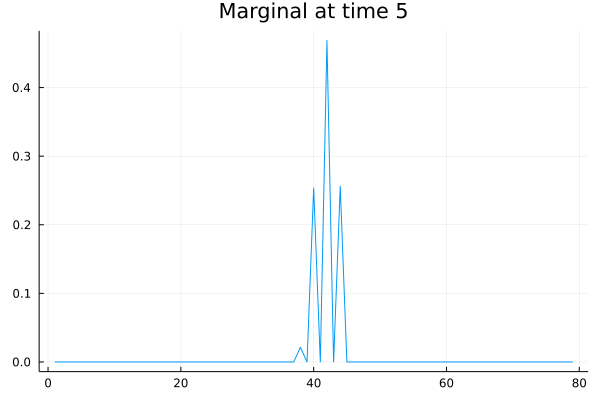

In [13]:
t = 5
plot(p_sptime[:,t],title="Marginal at time $t",legend=false)

## Parameters of CVA

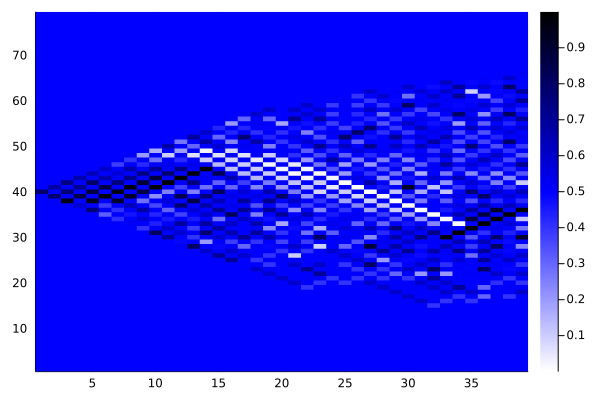

In [65]:
T = 40 #total time of movement
N = 2T - 1
cgrad(:matter)
Plots.heatmap(1:T-1,1:N,θ,c = [:white,:blue,:black])

### A plot of trajectories over the parameters
If you run the following cell many times you will see the trajectories over the space of parameters! You will see that many trajectories pass over the same set of parameters. 

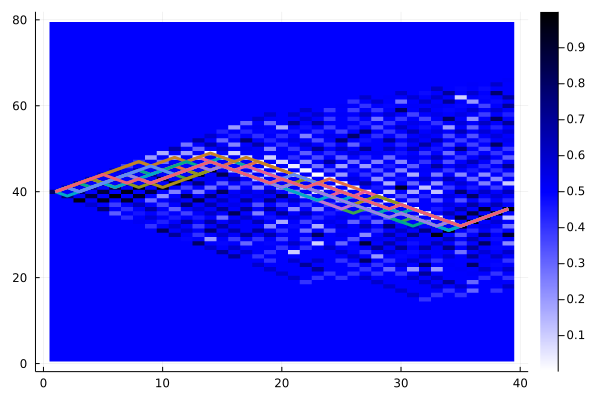

In [78]:
sample!(x,θ)
plot!(x[1:end-1] .+ T, legend = false,lw=3)

### Parameters appering at least in the 0.5% of trajectories sampled
We select here only the parameters which have at least the 0.5 % of trajectories using them. The idea is that many parameters are moved during the gradient descent, but are not used anymore at fixed point

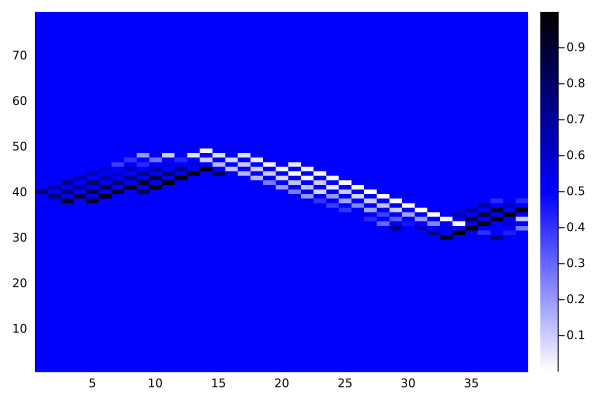

In [81]:
θfreq = 0.5 .+ zero(θ)
tot = 10000
for st = 1:tot
    sample!(x,θ)       
    for t=1:T-1
        θfreq[x[t] + T, t] += 1
    end
end
Plots.heatmap(1:T-1,1:N,((θfreq .> tot/200) .* θ) .+ ((θfreq .<= tot/200) .*  0.5) ,c = [:white,:blue,:black])
#savefig("heatmap.png")

### Parameters appearing only in trajectories which respect the hard constraint

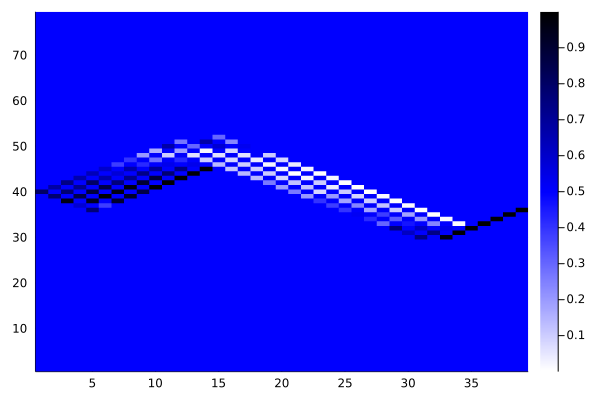

In [83]:
θfreq = 0.5 .+ zero(θ)
tot = 10000
for st = 1:tot
    sample!(x,θ) 
    if logO(x,windows) == 0              
        for t=1:T-1
            θfreq[x[t] + T, t] = θ[x[t] + T, t]
        end
    end
end
Plots.heatmap(1:T-1,1:N,θfreq ,c = [:white,:blue,:black])
#savefig("heatmap.png")

This and the previous plots are very similar. It means that the soft constrain

## Exact solution
We now check that the probability distribution found by CVA is consistent with the exact solution of this model

In [93]:
using LinearAlgebra, SparseArrays
A⊕B = kron(I(size(B,1)), A)+kron(B, I(size(A,1)))
lattice(n) = spdiagm(1=>trues(n-1),-1=>trues(n-1))
lattice(L...) = lattice(L[1])⊕lattice(L[2:end]...)
clattice(n) = (A=lattice(n); A[1,end]=A[end,1]=true; A)
clattice(L...) = clattice(L[1])⊕clattice(L[2:end]...)

N = 80
T = 40
i0 = N÷2
A = 1.0*lattice(N);
A ./= sum(A, dims=1)

function evolution(A,windows,t0,t,i0)
    C = I(size(A,1))
    for w in windows
        B = copy(A)
        B[1:w[2]-1+i0 ,:] .= 0
        B[w[3]+1+i0:end,:] .= 0
        C = A^(w[1]-1-t0) * C 
        C = B * C
        t0 = w[1]
    end
    return A^(t-t0) * C
    
end

function marginal(t,A,windows,T) 
    A1 = evolution(A,[w for w in windows if w[1] <= t],1,t,T) 
    A2 = evolution(A,[w for w in windows if w[1] > t],t,T,T)
    A3 = evolution(A,windows,1,T,T)
    return [sum(A2[:,i]) * A1[i,T] / sum(A3[:,T]) for i = 1:N]
end

marginal (generic function with 1 method)

In [94]:
T = 40
windows = [(15,5,15),(35,-15,-7),(40,-3,1)]

3-element Vector{Tuple{Int64, Int64, Int64}}:
 (15, 5, 15)
 (35, -15, -7)
 (40, -3, 1)

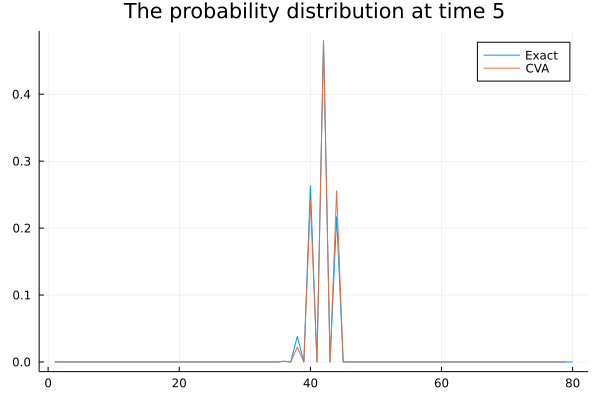

In [98]:
t = 5
plot(marginal(t,A,windows,T),label = "Exact",title="The probability distribution at time $t")
plot!(p_sptime[:,t] ./ sum(p_sptime[:,t]), label = "CVA")

## 